# Binary classification on the IMDB reviews dataset


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# %cd gdrive/MyDrive/my_ml_2023/session-7/

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random

# import import_ipynb
import utils



# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)


We start by downloading the IMDB dataset through `keras`, which comes in a standard train-test split.  This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words". As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

In [4]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data()

print(len(train_data))
print(len(test_data))
print(len(train_labels))
print(len(test_labels))

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
25000
25000
25000
25000


As you can see, we obtain 25,000 reviews in each data set, together with their corresponding binary labels (0 or 1, i.e. negative or positive). The words inside the actual reviews are represented by integers, reflecting the word's frequency ranking in the vocabulary. Each review is represented as a list of integers, that each encode a single word:

In [5]:
print(train_data[10][:100])

[1, 785, 189, 438, 47, 110, 142, 7, 6, 7475, 120, 4, 236, 378, 7, 153, 19, 87, 108, 141, 17, 1004, 5, 30432, 883, 10789, 23, 8, 4, 136, 13772, 11631, 4, 7475, 43, 1076, 21, 1407, 419, 5, 5202, 120, 91, 682, 189, 2818, 5, 9, 1348, 31, 7, 4, 118, 785, 189, 108, 126, 93, 13772, 16, 540, 324, 23, 6, 364, 352, 21, 14, 9, 93, 56, 18, 11, 230, 53, 771, 74, 31, 34, 4, 2834, 7, 4, 22, 5, 14, 11, 471, 9, 17547, 34, 4, 321, 487, 5, 116, 15, 6584, 4, 22]




 The highest integer is these series is consequently:

In [6]:
max([max(sequence) for sequence in train_data])

88586

In [7]:
min([min(sequence) for sequence in train_data])

1

It's both handy and a pity that theset words come preprocessed as integers, because it's difficult now to get a sense of what the original reviews looked like. Luckily, we can download a index-to-word dictionary for this dataset. The [indices](https://github.com/tensorflow/tensorflow/issues/42884) are offset by three to account for "padding", "start of sequence", "unknown", and "unused".

In [8]:
word_index = imdb.get_word_index() # word to index
reverse_word_index = dict([(value + 3 , key) for (key, value) in word_index.items()]) # index to word
reverse_word_index[0] = '[PAD]'
reverse_word_index[1] = '[START]'
reverse_word_index[2] = '[UNK]'
reverse_word_index[3] = '[UNS]'


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This dictionary allows us to "decode" the sequence of integers, so that we can look at an example:

In [9]:
decoded_review = ' '.join([reverse_word_index[i] for i in train_data[0]])
decoded_review

"[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

Let's decode all data back:

In [10]:
decoded_train_data = []

for item in train_data:
  decoded_review = ' '.join([reverse_word_index[i] for i in item])
  decoded_train_data.append(decoded_review)


In [11]:
decoded_test_data = []

for item in test_data:
  decoded_review = ' '.join([reverse_word_index[i] for i in item])
  decoded_test_data.append(decoded_review)

In this session, we'll work with a  **TF-IDF** (Term Frequency-Inverse Document Frequency) representation. This representation is used to determine how important a word is within a document compared to a collection of documents (corpus). It takes into account both how frequently the word appears in the document (Term Frequency) and how unique it is across the entire corpus (Inverse Document Frequency). Words with higher TF-IDF scores are considered more significant in representing the content of a document.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

x_train = tfidf_vectorizer.fit_transform(decoded_train_data).todense()
x_test = tfidf_vectorizer.transform(decoded_test_data).todense()

y_train = np.asarray(train_labels)
y_test = np.asarray(test_labels)

x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

print(x_train.shape)
print(x_dev.shape)
print(x_test.shape)

print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)



(22500, 5000)
(2500, 5000)
(25000, 5000)
(22500,)
(2500,)
(25000,)


Remember, with `PyTorch` it's important to convert your data to the appropriate `DataLoader` type. Let's define the `np2iter` function for that:

In [13]:
def np2iter(x, y, shuffle=True):
  x = torch.tensor(x, dtype=torch.float)
  y = np.expand_dims(y, axis=1)
  y = torch.tensor(y, dtype=torch.float)

  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=32, shuffle=shuffle)

train_iter = np2iter(x_train, y_train, shuffle=True)
dev_iter =  np2iter(x_dev, y_dev, shuffle=False)
test_iter =  np2iter(x_test, y_test, shuffle=False)


We are now ready to start building our model... As you will see, terribly little changes with respect to last week:

In [14]:
class BinaryModel(nn.Module):
  def __init__(self, in_features=1, out_features=1):
    super(BinaryModel, self).__init__()
    self.layer = nn.Linear(in_features=in_features, out_features=out_features)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
     x = self.layer(x)
     return self.sigmoid(x)


classification_model = BinaryModel(in_features=x_train.shape[1], out_features=1)
classification_model = classification_model.cuda()


In fact, the only thing that changes (in comparison to regression) is our **activation function**, which is now a **sigmoid**. The function garantees that our output scalar is "squashed" between 0 and 1. This function is very commonly used in many fields:

In [15]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

print([sigmoid(x) for x in (200., -382.,  1000., 0.88)])

[1.0, 1.2574997661299533e-166, 1.0, 0.7068222210935676]


We can easily visualize the squashing operation which this function achieves:

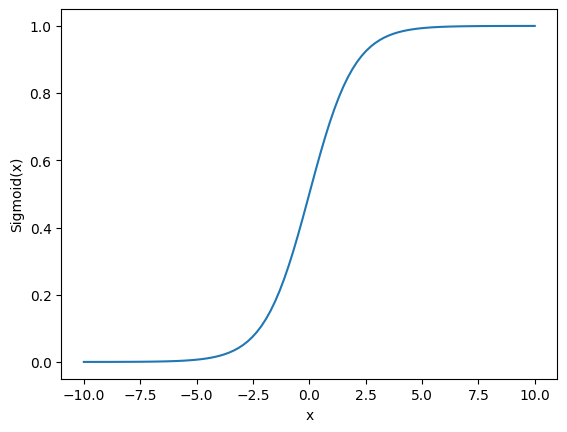

In [16]:
x = np.linspace(-10, 10, 100)
z = sigmoid(x)
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Sigmoid(x)")
plt.show()

We have created our model, so we can already use it to make predictions -- although the weights are still random and haven't been optimized yet:

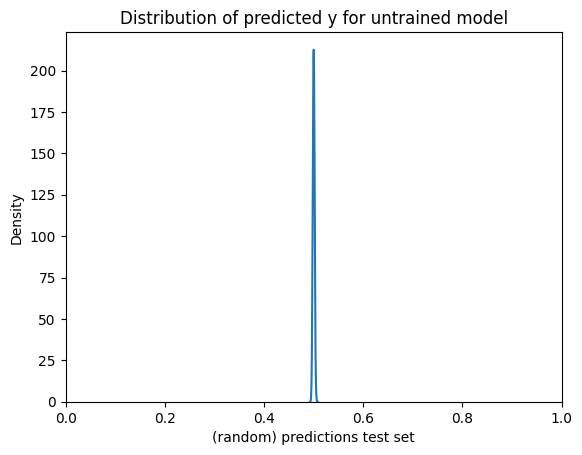

In [ ]:
y_pred = utils.test(classification_model, test_iter)
sns.kdeplot(y_pred.squeeze())
plt.xlabel('(random) predictions test set')
plt.title('Distribution of predicted y for untrained model')
plt.xlim((0, 1));

The distribution of these output values is a pretty perfect bell curve, with a mean around 0.5, indicating that the model is still blissfully ignorant. It resorts to a safe betting strategy, with a mean exactly between 0 and 1.

Again, nothing much new, so far, except for the **accuracy metric** that we should define as an additional metric. Importantly, only the loss is used for the optimization. Scores like **accuracy** or  **F1** are only used *post-hoc* in deep learning, since the optimization only uses the actual loss in backpropagation. We will use [Binary Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), which is a common loss/objective function for binary classification. We will discuss it a bit later.

In [18]:
from sklearn.metrics import accuracy_score

def val_acc(y_pred, y_test):
  y_pred[y_pred >= 0.5] = 1
  y_pred[y_pred < 0.5] = 0
  return accuracy_score(y_pred=y_pred, y_true=y_test)

 Let us now train the model for 15 epochs:

In [19]:
history = utils.train(model=classification_model,
                            loss=nn.BCELoss(),
                            val_metrics={"bce": nn.BCELoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=0.1),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=15)

epoch 1 train loss: 0.6790 val_bce: 0.6657 val_acc: 0.7756
epoch 2 train loss: 0.6528 val_bce: 0.6423 val_acc: 0.7872
epoch 3 train loss: 0.6302 val_bce: 0.6234 val_acc: 0.7420
epoch 4 train loss: 0.6106 val_bce: 0.6044 val_acc: 0.7964
epoch 5 train loss: 0.5934 val_bce: 0.5888 val_acc: 0.8008
epoch 6 train loss: 0.5780 val_bce: 0.5748 val_acc: 0.8076
epoch 7 train loss: 0.5643 val_bce: 0.5622 val_acc: 0.8084
epoch 8 train loss: 0.5517 val_bce: 0.5509 val_acc: 0.8120
epoch 9 train loss: 0.5403 val_bce: 0.5403 val_acc: 0.8140
epoch 10 train loss: 0.5299 val_bce: 0.5307 val_acc: 0.8204
epoch 11 train loss: 0.5202 val_bce: 0.5219 val_acc: 0.8224
epoch 12 train loss: 0.5114 val_bce: 0.5140 val_acc: 0.8192
epoch 13 train loss: 0.5031 val_bce: 0.5062 val_acc: 0.8236
epoch 14 train loss: 0.4954 val_bce: 0.4990 val_acc: 0.8288
epoch 15 train loss: 0.4882 val_bce: 0.4925 val_acc: 0.8264


As last week, we can plot values from the history project to visualize the optimization process:

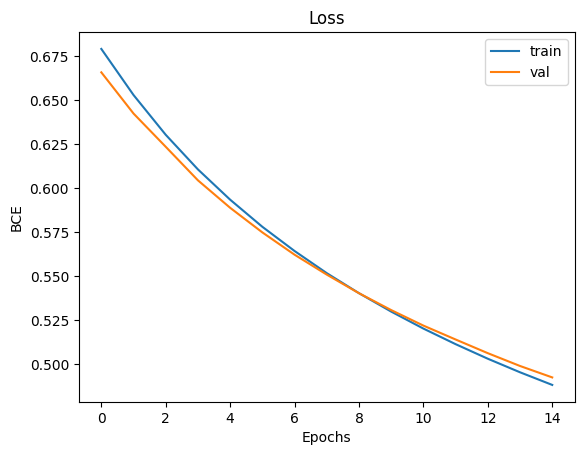

In [20]:
plt.plot(history["train_loss"], label='train')
plt.plot(history["val_bce"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE');
plt.legend()

The loss was still steadily going -- so we could have trained  for longer!

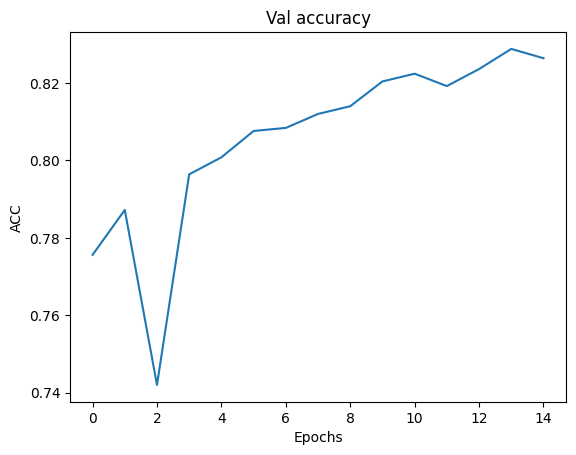

In [21]:
plt.plot(history["val_acc"])
plt.title('Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC');

The accuracy was also still steadily going up, which is healthy. We can now look at the scores which the model predicts for the test data now after a few rounds of training:

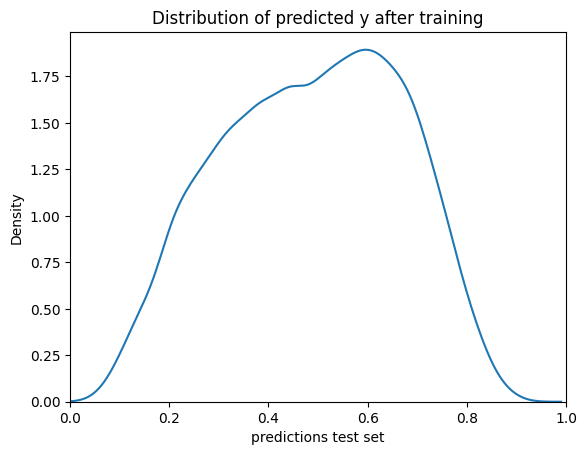

In [22]:
y_pred = utils.test(classification_model, test_iter)
sns.kdeplot(y_pred.squeeze())
plt.xlabel('predictions test set')
plt.title('Distribution of predicted y after training')
plt.xlim((0, 1));



The distribution has a much larger variance now and a different kind of "tail skew" on each side of the mean. It appears that it has learned at least something.  The only way to find out how well it did, is to **binarize** the output again, into zeroes and one. We'll use a simple **threshold** at 0.5 to implement our **decision function** for this model:

In [23]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
print(y_pred.shape)
print(y_pred[:10])

torch.Size([25000, 1])
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]])


After this conversion, we can again resort to `sklearn`'s standard evaluation metrics to find out how well we do on the test data:

In [24]:
from sklearn.metrics import classification_report
print(accuracy_score(y_pred=y_pred, y_true=y_test))
print(classification_report(y_pred=y_pred, y_true=y_test))

0.82744
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     12500
           1       0.83      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



# Let's go deeper

Let's add one additional layer to our previous model:

In [25]:
class DeeperModel(nn.Module):
  def __init__(self, in_features=1, out_features=1):
    super(DeeperModel, self).__init__()
    self.layer1 = nn.Linear(in_features=in_features, out_features=in_features//10)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(in_features=in_features//10, out_features=out_features)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
     x = self.layer1(x)
     x = self.relu(x)
     x = self.layer2(x)
     return self.sigmoid(x)


deeper_model = DeeperModel(in_features=x_train.shape[1], out_features=1)
deeper_model = deeper_model.cuda()

In [26]:
history = utils.train(model=deeper_model,
                            loss=nn.BCELoss(),
                            val_metrics={"bce": nn.BCELoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(deeper_model.parameters(), lr=0.1),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=15)

epoch 1 train loss: 0.6893 val_bce: 0.6799 val_acc: 0.7128
epoch 2 train loss: 0.6385 val_bce: 0.5937 val_acc: 0.6632
epoch 3 train loss: 0.4831 val_bce: 0.4497 val_acc: 0.7960
epoch 4 train loss: 0.3642 val_bce: 0.3501 val_acc: 0.8528
epoch 5 train loss: 0.3097 val_bce: 0.4185 val_acc: 0.7920
epoch 6 train loss: 0.2796 val_bce: 0.2901 val_acc: 0.8808
epoch 7 train loss: 0.2581 val_bce: 0.2810 val_acc: 0.8864
epoch 8 train loss: 0.2433 val_bce: 0.2911 val_acc: 0.8788
epoch 9 train loss: 0.2324 val_bce: 0.2896 val_acc: 0.8804
epoch 10 train loss: 0.2216 val_bce: 0.2789 val_acc: 0.8848
epoch 11 train loss: 0.2146 val_bce: 0.6087 val_acc: 0.7372
epoch 12 train loss: 0.2079 val_bce: 0.2936 val_acc: 0.8732
epoch 13 train loss: 0.2028 val_bce: 0.3873 val_acc: 0.8396
epoch 14 train loss: 0.2009 val_bce: 0.2905 val_acc: 0.8756
epoch 15 train loss: 0.1920 val_bce: 0.2955 val_acc: 0.8752


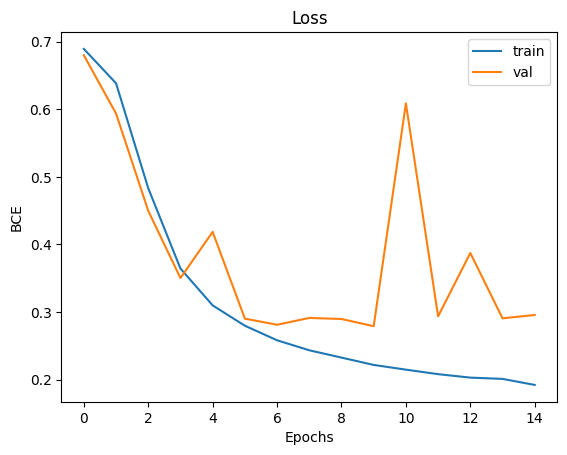

In [27]:
plt.plot(history["train_loss"], label='train')
plt.plot(history["val_bce"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE');
plt.legend()

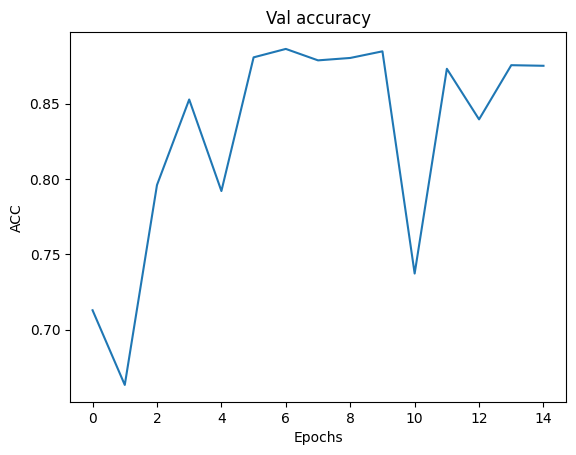

In [28]:
plt.plot(history["val_acc"])
plt.title('Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC');

In [29]:
y_pred = utils.test(deeper_model, test_iter)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

Results now are much better!

In [30]:
print(accuracy_score(y_pred=y_pred, y_true=y_test))
print(classification_report(y_pred=y_pred, y_true=y_test))

0.87088
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     12500
           1       0.92      0.82      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.88      0.87      0.87     25000
weighted avg       0.88      0.87      0.87     25000



That was all: it required a minimal adaptation to move from last week's linear model to a binary (deeper) classification model. The only new thing was the sigmoid activation, new loss function and new scoring metric, because we are working with classes now instead of scalars.

Only final thing though relates to **batching**: deep learning datasets can be very large and require lots of memory. While it's typically not a problem to load these into the RAM of your traditional computer, the datasets are typically too large to fit into the GPU, where heavier networks have to be optimized. For this, deep learning relies on the mechanism of **batching**. Batching means that the dataset is divided into smaller subsets of an equal size, which are called **(mini-)batches** and which do fit into the GPU. Typically, these batches and randomly selected and they get "reshuffled" after each epoch. The backpropagation etc. is then done for each minibatch **separately** inside an epoch.

In this case, we are using a batch size of 32, so that each time the training happens for a small subset of 32 reviews. This (finally!) explains the **loop** over our dataset that you see for each epoch.

Finding a suitable batch size can be tricky and this involves a trade-off.

In the **test phase**, it is a trade-off between speed and memory. The bigger the batch, the faster we get all predictions (but size of the batch depends on the GPU memory)

In the **training phase**, it is a trade-off between quality of training and memory. The bigger the batch, the faster convergence (less iterations) of the network due to better approximation of the gradients for optimization. Small batches might lead to noisy gradients (so we might make a step in the wrong direction) and to slower convergence.

How to select a good batch size then? This will often be an *ad hoc* decision, that depends on the peculiarities of your model, task, and data. For larger datasets, the choice is often easiest in the sense that you'll want to maximize the number of instances that you can fit into the GPU in one batch (in addition to your actual model, which *also* has to fit into there). In general:
- A default of "64" would often be a good value for a batch size to start experimenting with. People can use very small batch sizes sometimes (even of 1!), but we have rarely seen batch size over 500, for instance.
- Shuffling and "rebatching" the data at each epoch (which is default in keras), is probably a good strategy to combat overfitting.